# Advancedコース卒業試験

## 課題
あなたは以下の案件でお客さんから以下のタスクが技術的に可能かどうか検証して欲しいと依頼を受けました。実際にモデルを組んで分析した上で、検証結果をテキストでまとめてください。
テキストはコードを書いたnotebookにmarkdown形式で記入し、コードと併せて提出してください。

**案件：米国の各郡の様々なデータから、その郡におけるがん死亡率を予測するモデルを作成したい。
ただし、最小二乗誤差基準のCVEをできるだけ小さくなるようにしたい。**

対象データ:https://data.world/nrippner/ols-regression-challenge<br>
**目標:CVE<0.5<br>**
**合格:CVE<0.506<br>**

[検証結果]
・CVE基準値を達成し、目標値を下回るモデルを作成することができた。

・モデル選択においては、モデル学習スピードの速さと精度の高さで知られる勾配ブースティングのひとつであるxgboostを用いたが、
ほかのいくつかのモデルを用いても同様にcve基準値を下回ったことから、今回の案件は技術的に可能であると言える。

以下コード

In [1]:
#データの読み込み
import numpy as np
import pandas as pd
df = pd.read_csv('https://query.data.world/s/kx7k73w2jlzaohyfbm7rzxhqj4j4an',encoding='iso-8859-1')
pd.set_option('display.max_columns', None)

In [2]:

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
# CVE評価用コード
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
# cross_val_score(model, X, y,cv=5,scoring=make_scorer(mean_squared_error))

まずは、データの中身を確認する。

In [4]:
df.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,MedianAgeFemale,Geography,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",2.54,52.5,11.5,39.5,42.1,6.9,23.2,19.6,51.9,8.0,75.1,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",2.34,44.5,6.1,22.4,64.0,7.5,26.0,22.7,55.9,7.8,70.2,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",2.62,54.2,24.0,36.6,NaN,9.5,29.0,16.0,45.9,7.0,63.7,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",2.52,52.7,20.2,41.2,36.1,2.5,31.6,9.3,48.3,12.1,58.4,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",2.34,57.8,14.9,43.0,40.0,2.0,33.4,15.0,48.2,4.8,61.6,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [5]:
df['Geography'].nunique()

3047

'Geography'列を州ごとの情報にすることで説明変数に組み込む

In [6]:
# Geographyの変数化
df['State'] = [df['Geography'][i].split(',')[1] for i in range(df.shape[0])]
df = pd.get_dummies(df, columns=["State"])
df = df.drop('Geography', axis=1)

In [7]:
# 型を揃える
df["medIncome"] = df["medIncome"].astype('float')
df['avgDeathsPerYear'] = df['avgDeathsPerYear'].astype('float')
df["popEst2015"] = df["popEst2015"].astype('float')

In [8]:
# 目的変数と関連すると思われる新たな変数を追加
df["Death rate"] = (df["avgDeathsPerYear"]/df["popEst2015"])*100000

In [9]:
# 'binnedInc'はカテゴリデータであり、medIncomeを代用
df = df.drop('binnedInc', axis=1)


データの欠損値確認

In [10]:
df.drop('TARGET_deathRate',axis=1).isnull().sum()

avgAnnCount             0
avgDeathsPerYear        0
incidenceRate           0
medIncome               0
popEst2015              0
                       ..
State_ Washington       0
State_ West Virginia    0
State_ Wisconsin        0
State_ Wyoming          0
Death rate              0
Length: 83, dtype: int64

In [11]:
# 'PctSomeCol18_24'は欠損値が多く消去
df = df.drop('PctSomeCol18_24', axis=1)

In [12]:
# "PctEmployed16_Over","PctPrivateCoverageAlone"は平均値で欠損値補完
df["PctEmployed16_Over"] = df["PctEmployed16_Over"].fillna(df["PctEmployed16_Over"].mean())
df["PctPrivateCoverageAlone"] = df["PctPrivateCoverageAlone"].fillna(df["PctPrivateCoverageAlone"].mean())

説明変数と目的変数の定義

In [13]:
y = df.loc[:,["TARGET_deathRate"]].values
X = df.drop('TARGET_deathRate',axis=1).values
# 目的変数の標準化
import scipy.stats
y = scipy.stats.zscore(y)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [ ]:
# # 各説明変数の分布の図示
# for col in range(len(X)):
#     ax = sns.distplot(X[:,col])
#     print(col)
#     plt.show()

変数の分布の偏りを解消する

In [15]:
#非線形変換
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
pt.fit(y_train)


y_train = pt.transform(y_train)
y_test = pt.transform(y_test)

# clipping
for col_num in range(X.shape[1]):
    p01 = float(pd.DataFrame(X_train[:,col_num]).quantile(0.01))
    p99 =  float(pd.DataFrame(X_train[:,col_num]).quantile(0.99))
    X_train[:,col_num] = np.clip(X_train[:,col_num],p01,p99)
    X_test[:,col_num] = np.clip(X_test[:,col_num],p01,p99) 

In [16]:
# 説明変数の標準化
from sklearn.preprocessing import StandardScaler
scaler_x_train = StandardScaler()
scaler_x_train.fit(X_train)

X_train_std = scaler_x_train.transform(X_train)
X_test_std = scaler_x_train.transform(X_test)

汎用性の高いモデルとして知られる勾配ブースティングのひとつであるxgboostによって学習させる。

(https://qiita.com/yh0sh/items/1df89b12a8dcd15bd5aa)


In [18]:
# チューニング
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

params = {"learning_rate":[0.1,0.3,0.5],
        "max_depth": [2,3,5,10],
         "subsample":[0.5,0.8,0.9,1],
         "colsample_bytree": [0.5,1.0],
         }
# モデルにインスタンス生成
xgd = xgb.XGBRegressor()
# ハイパーパラメータ探索
cv = GridSearchCV(xgd, params, cv = 10, scoring= 'neg_mean_squared_error', n_jobs =-1)
cv.fit(X_train_std,y_train)


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_par

In [19]:
best_model = cv.best_estimator_

In [20]:
best_params = cv.best_params_

In [21]:
cross_val_score(best_model, X_test_std, y_test, cv=5,scoring=make_scorer(mean_squared_error)).mean()

0.258895415425318

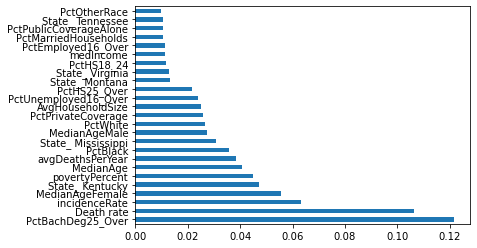

In [22]:
feature_importances = pd.Series(best_model.feature_importances_, index=df.drop('TARGET_deathRate',axis=1).columns)
feature_importances.nlargest(25).plot.barh()

[考察]
・目的変数に寄与すると考え新たな説明変数を作った「Death rate」の寄与度が大きく、納得感のある結果となった。
・25歳以上の住民で、学士号取得者の割合を示す「PctBachDeg25_Over」が最も大きな寄与度を示す値となったが、今回の分析結果から原因を考えることはできなかった。追加調査が必要である。
・いくつかの州の説明変数の寄与度が大きい結果となった。この背景には、州ごとの人々の食生活や気候、住環境などの違いが影響していると考えられ、更なる調査が期待される。

Apendix.
ランダムフォレスト/リッジ回帰でも同様に合格基準であるCVE<0.5を達成
(パラメーターチューニングによって更なる精度向上が期待できる)

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# 学習に関するパラメータ設定
params = {
    "n_estimators" : [2, 5, 10, 15, 20, 30, 50, 75, 100, 200, 500, 1000],
    "criterion" : ["mse"],
    "min_samples_split" : [2, 3, 5, 10, 15, 20, 30],
    "max_depth" : [2, 3, 5, 10, 15, 20, 30],        
    "random_state" : [0],
    "verbose" : [False],
}

# モデル構築(ランダムフォレストで実行)
model = GridSearchCV(RandomForestRegressor(), params, cv = 5)
model.fit(X_train_std, y_train)
model = model.best_estimator_

# 検証用セットを用いて評価
cross_val_score(model, X_test_std, y_test, cv=5,scoring=make_scorer(mean_squared_error))

array([0.50858924, 0.63455856, 0.42243978, 0.44298263, 0.37969418])

In [93]:
feature_importances = pd.Series(model.feature_importances_, index=df.drop('TARGET_deathRate',axis=1).columns)
feature_importances.nlargest(25).plot.barh()

ValueError: Length of passed values is 132, index implies 82.

In [34]:
cross_val_score(model, X_test_std, y_test, cv=5,scoring=make_scorer(mean_squared_error)).mean()

In [47]:
from sklearn.linear_model import Ridge, Lasso
ridge = Ridge()
ridge.fit(X_train_std,y_train)

Ridge()

In [51]:
cross_val_score(ridge, X_test_std, y_test, cv=5,scoring=make_scorer(mean_squared_error)).mean()

0.2249148254315329

In [49]:
lss = Lasso()
lss.fit(X_train_std,y_train)

Lasso()

In [52]:
cross_val_score(lss, X_test_std, y_test, cv=5,scoring=make_scorer(mean_squared_error)).mean()

0.9759890258289902